# Week 2: Principal Component Analysis

**Isaac Y, Brandon C, Natalia M** 

In this workshop, we will work through a set of problems on dimensionality reduction -- a cannonical form of unsupervised learning. Within the machine learning pipeline, dimensionality reduction is an important tool, which can used in EDA to understand patterns in the data, feature engineering to create a low-dimensional representation of the inputs, and/or in the final phase when you are presenting and visualizing your solution.

As usual, the worksheets will be completed in teams of 2-3, using **pair programming**, and we have provided cues to switch roles between driver and navigator. When completing worksheets:

>- You will have tasks tagged by (CORE) and (EXTRA). 
>- Your primary aim is to complete the (CORE) components during the WS session, afterwards you can try to complete the (EXTRA) tasks for your self-learning process. 
>- Look for the 🏁 as cue to switch roles between driver and navigator.
>- In some Exercises, you will see some beneficial hints at the bottom of questions.

Instructions for submitting your workshops can be found at the end of worksheet. As a reminder, you must submit a pdf of your notebook on Learn by 16:00 PM on the Friday of the week the workshop was given. 

As you work through the problems it will help to refer to your lecture notes (navigator). The exercises here are designed to reinforce the topics covered this week. Please discuss with the tutors if you get stuck, even early on! 

## Outline

1. [Problem Definition and Setup](#setup)

2. [Principal Component Analysis](#pca)

    a. [Examining the Basis Vectors and Scores](#basis)

    b. [Selecting the Number of Components](#nocomponents)

    c. [Other Digits](#other)

3. [Kernel PCA](#kpca)

# Problem Definition and Setup <a id='setup'></a>

## Packages

First, lets load in some packages to get us started. 

In [3]:
import matplotlib.pyplot as plt  # plotting API (Matplotlib)
import seaborn as sns  # statistical plotting styles/helpers (Seaborn)
import numpy as np  # numerical arrays and linear algebra (NumPy)
import pandas as pd  # tabular data structures (pandas)
from sklearn.decomposition import PCA  # principal component analysis transformer
from sklearn.preprocessing import StandardScaler  # z-score standardization transformer

## Data

Our dataset will be the famous [MNIST](http://yann.lecun.com/exdb/mnist/) dataset of handwritten digits, which we will download from sklearn. The dataset consists of a set of greyscale images of the numbers 0-9 and corresponding labels. Usually the goal is to train a classifier (i.e. given an image, what digit does it correspond to?). Here we will throw away the labels and focus on the images themselves. Specifically, we will use dimensionality reduction to explore the images and underlying patterns and find a low-dimensional representation.

First, load the data:

In [4]:
from sklearn.datasets import fetch_openml  # utility to download datasets from OpenML

mnist = fetch_openml('mnist_784', parser='auto')  # load MNIST (784 features/pixels per image)
X = mnist.data  # feature matrix: rows are images, columns are pixel intensities
y = mnist.target  # labels/targets: digit class for each image (often stored as strings)

### 🚩 Exercise 1 (CORE)

What is stored in `X` and `y` in the command above? What is the shape/datatype etc if an array?


In [5]:
X

# X is a dataframe of pixel intensities at certain locations
# There are 70000 28x28 images and they are flattened into vectors of length 784

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
y

# Each entry in y corresponds to a row index in X
# It tells you what number that vector corresponds with

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

For X:

    X is a dataframe of pixel intensities at certain locations. There are 70000 28x28 images and they are flattened into vectors of length 784.
For Y: 
    
    Each entry in y corresponds to a row index in X. It tells you what number that vector corresponds with. 

Now, let's create a dictionary, with the digit classes (0-9) as keys, where the correponding values are the set of all images corresponding to that particular label. 

In [7]:
digits_dict = {}  # initialise dict: label (0-9) -> list of image vectors
X_ = X.values  # convert the pandas DataFrame `X` into a NumPy array for fast row indexing
count = 0  # row counter to keep X_ aligned with the current label in `y`

for label in y:  # iterate over each label in the same order as the rows of `X`
  if label in digits_dict:  # if we've seen this label before, append to its list
    digits_dict[label] += [X_[count]]  # add the current image (row) to the label's list
  else:  # if this is the first time we see this label, create the list
    digits_dict[label] = [X_[count]]  # start a new list containing the current image (row)
  count += 1  # increment row index so the next label matches the next image

Next let's visualize some of the images. We will start by picking a label and plotting a few images from within the dictionary. Note that each image contains a total of 784 pixels (28 by 28) and we will need to `reshape` the image to plot with `imshow(...,cmap='gray_r')`. Try also changing the label to view different digits.

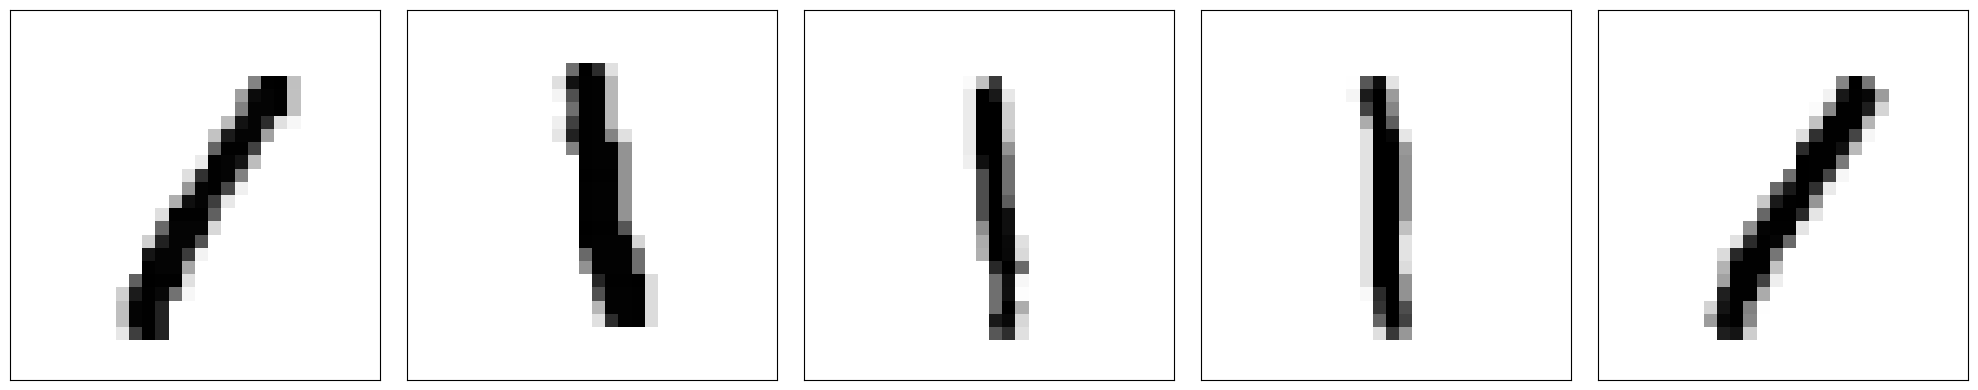

In [8]:
mylabel = '1'  # choose which digit label to visualise (as stored in `y`, often strings like '1')
n_images_per_label = 5  # how many examples of this digit to plot

fig = plt.figure(figsize=(4 * n_images_per_label, 4))  # create a figure sized to fit `n_images_per_label` images
for j in range(n_images_per_label):  # loop over the first `n_images_per_label` images for this label
    ax_number = 1 + j  # subplot index (Matplotlib subplots are 1-indexed here)
    ax = fig.add_subplot(1, n_images_per_label, ax_number)  # add a subplot in a 1 x n_images_per_label grid
    ax.imshow(digits_dict[mylabel][j].reshape((28, 28)), cmap='gray_r')  # reshape vector -> 28x28 and plot in grayscale
    ax.set_xticks([])  # hide x-axis tick marks for cleaner image display
    ax.set_yticks([])  # hide y-axis tick marks for cleaner image display
fig.tight_layout()  # automatically adjust spacing so subplots don't overlap

### 🚩 Exercise 2 (EXTRA)

Edit the code above to plot a few images for multiple labels.

<br>
<details><summary><b><u>Hint</b></u></summary>

Create a vector of labels and add additional for loop in the code above.
</details>

In [9]:
# Code for your answer here!

### 🚩 Exercise 3 (CORE)

Now focus on the 3s only and create a data matrix called `X_threes`. Define also `N` (# datapoints) and `D` (# features).

What are the features in this problem? How many features and data points are there? 

In [10]:
X_threes = np.array(X[y == "3"].reset_index(drop=True))

N = X_threes.shape[0]
D = X_threes.shape[1]

The features are the different pixel locations. There are 784 features and 7141 data points.

### 🚩 Exercise 4 (CORE)

Now compute and plot the mean image of three.

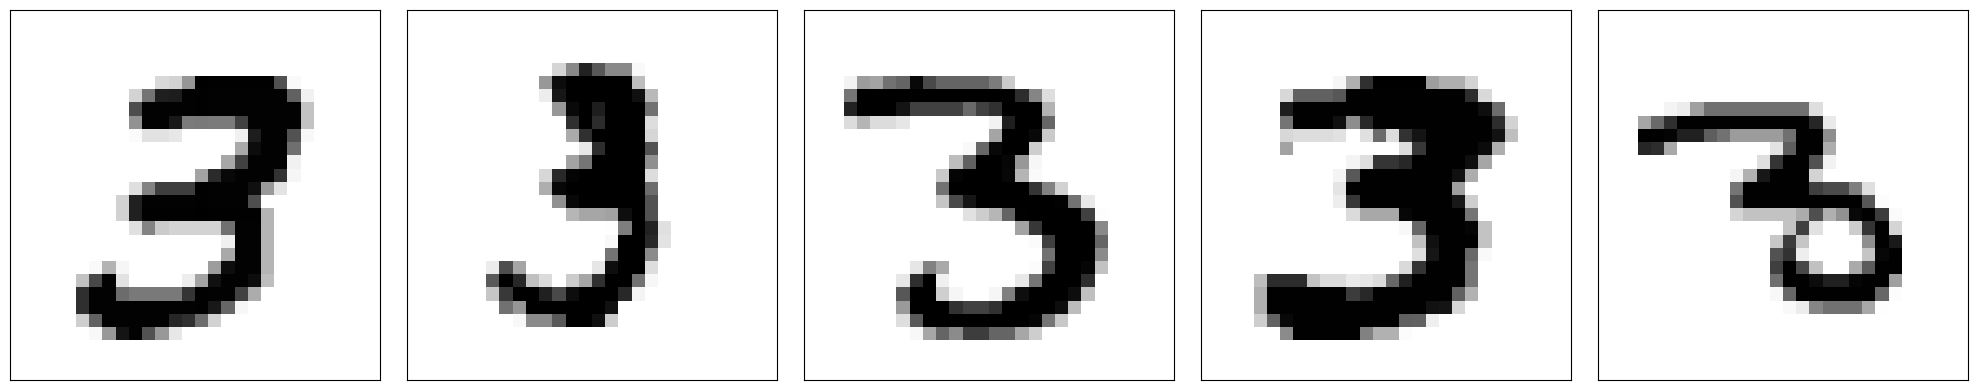

In [11]:
mylabel = '3'  # choose which digit label to visualise (as stored in `y`, often strings like '1')
n_images_per_label = 5  # how many examples of this digit to plot

fig = plt.figure(figsize=(4 * n_images_per_label, 4))  # create a figure sized to fit `n_images_per_label` images
for j in range(n_images_per_label):  # loop over the first `n_images_per_label` images for this label
    ax_number = 1 + j  # subplot index (Matplotlib subplots are 1-indexed here)
    ax = fig.add_subplot(1, n_images_per_label, ax_number)  # add a subplot in a 1 x n_images_per_label grid
    ax.imshow(digits_dict[mylabel][j].reshape((28, 28)), cmap='gray_r')  # reshape vector -> 28x28 and plot in grayscale
    ax.set_xticks([])  # hide x-axis tick marks for cleaner image display
    ax.set_yticks([])  # hide y-axis tick marks for cleaner image display
fig.tight_layout()  # automatically adjust spacing so subplots don't overlap

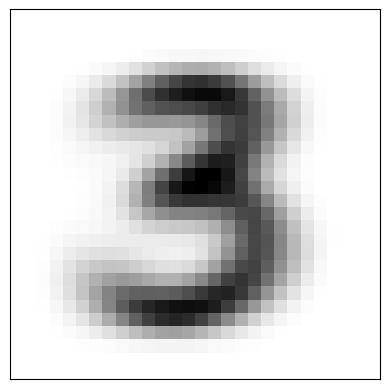

In [12]:
X_three_mean = np.array(X_threes.mean(axis=0))

fig, ax = plt.subplots()  # add a subplot in a 1 x n_images_per_label grid
ax.imshow(X_three_mean.reshape((28, 28)), cmap='gray_r')  # reshape vector -> 28x28 and plot in grayscale
ax.set_xticks([])  # hide x-axis tick marks for cleaner image display
ax.set_yticks([])

plt.show()

Run the following code to first create a new data matrix that centers the data by subtracting the mean image, and then visualise some of the images and compare to the original data. Note: you will need to replace `X_three_mean` with the name you gave the mean image in the computation above.

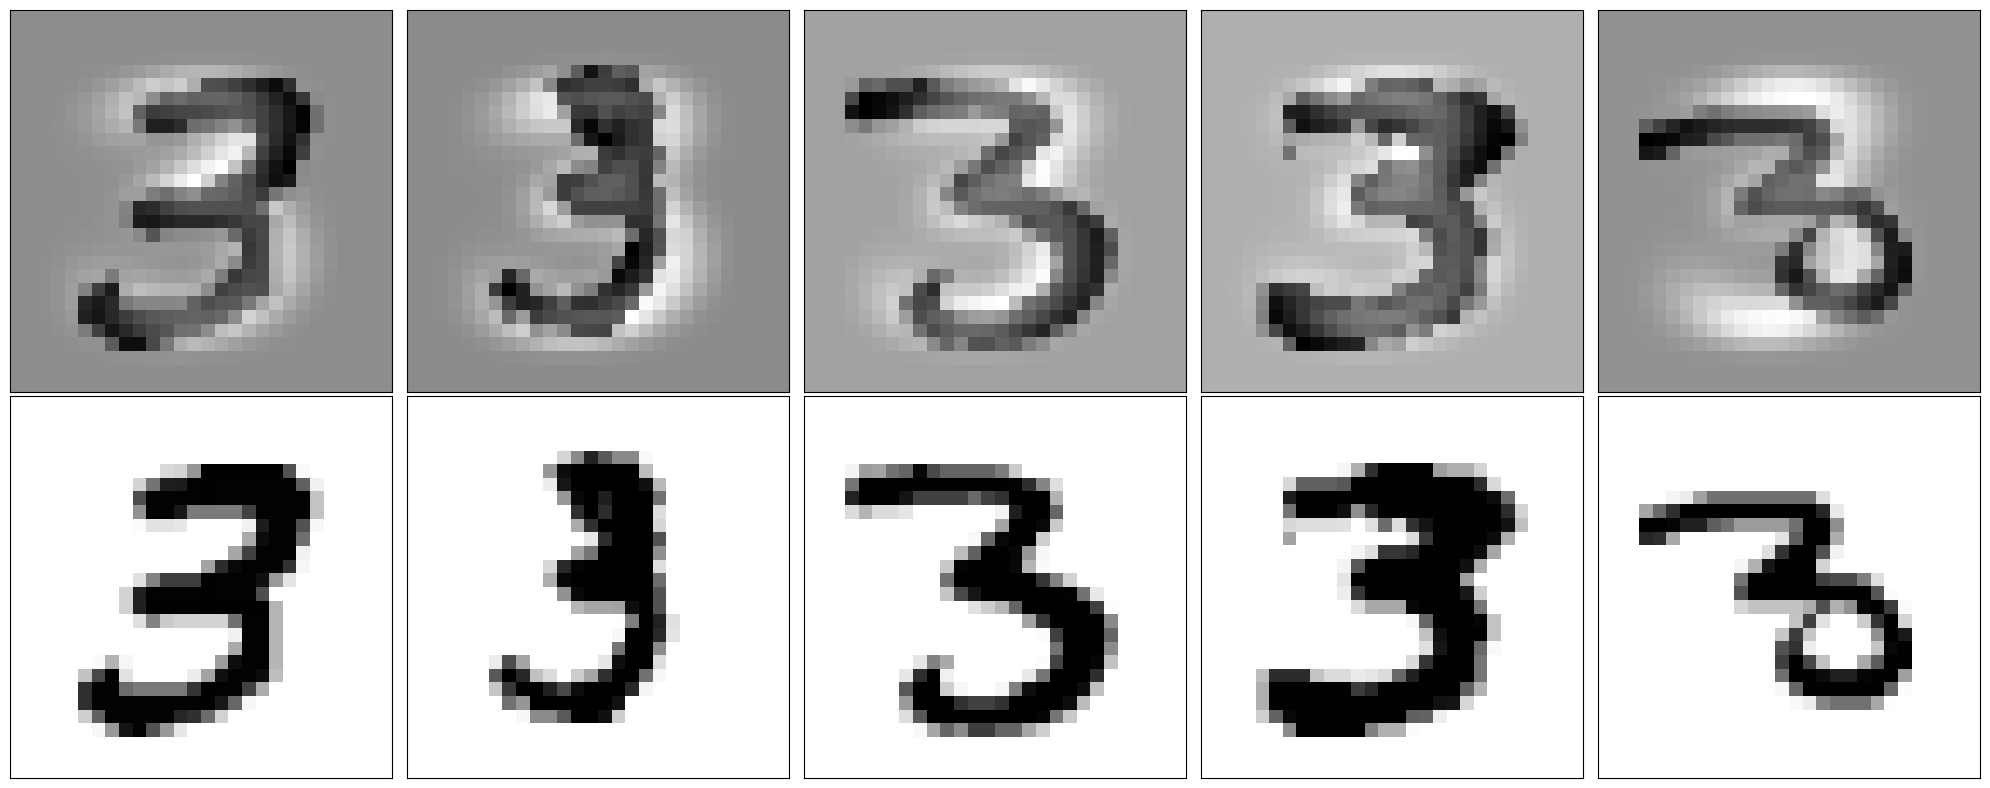

In [13]:
X_three_centred = X_threes - X_three_mean  # centre each image by subtracting the mean image (pixel-wise)

n_images = 5  # number of example images to show

fig = plt.figure(figsize=(4 * n_images, 4 * 2))  # create a figure with 2 rows (centred vs original)
for j in range(n_images):  # loop over a few images to visualise
  ax = fig.add_subplot(2, n_images, j + 1)  # top row: centred images
  ax.imshow(X_three_centred[j, :].reshape((28, 28)), cmap='gray_r')  # reshape and plot centred image j
  ax.set_xticks([])  # hide x ticks
  ax.set_yticks([])  # hide y ticks

  ax = fig.add_subplot(2, n_images, j + 1 + n_images)  # bottom row: original (uncentred) images
  ax.imshow(X_threes[j, :].reshape((28, 28)), cmap='gray_r')  # reshape and plot original image j
  ax.set_xticks([])  # hide x ticks
  ax.set_yticks([])  # hide y ticks
fig.tight_layout()  # adjust subplot spacing

In [14]:
X_threes - X_three_mean

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(7141, 784))

### 🚩 Exercise 5 (CORE)

Comment on whether or not the images need to be standardized before using PCA

The images do not need to be standardized because all of the features are in the same "units".

🏁 **Now, is a good point to switch driver and navigator**

# PCA <a id='pca'></a>

Now, we will perform PCA to summarize the main patterns in the images. We will use the [`PCA()`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) transformer from the `sklearn.decomposition` package:

- As we saw last week, we start by creating our transformer object, specifying any parameters as desired. For example, we can specify the number of components with the option `n_components`. If omitted, all components are kept.

- Note that by default the `PCA()` transform centers the variables to have zero mean (but does not scale them). 

- After calling `.fit()`, our fitted object has a number of attributes, including:
    - the mean accessible through the attribute `mean_`.
    - the basis vectors (principal components) accesible through the `components_` attribute.

- There are also a number of methods for the fitted object, including `.transform()` to obtain the low-dimensional representation (or also `fit_transform` combining both together). 

 First, let's create the PCA transformer object and call `.fit()`:

In [15]:
pca_threes = PCA(n_components=200)  # create PCA object keeping the first 200 principal components
pca_threes.fit(X_threes)  # fit PCA to the digit-3 data (computes mean and components)

,"n_components n_components: int, float or 'mle', default=NoneNumber of components to keep.if n_components is not set all components are kept:: n_components == min(n_samples, n_features)If ``n_components == 'mle'`` and ``svd_solver == 'full'``, Minka'sMLE is used to guess the dimension. Use of ``n_components == 'mle'``will interpret ``svd_solver == 'auto'`` as ``svd_solver == 'full'``.If ``0 < n_components < 1`` and ``svd_solver == 'full'``, select thenumber of components such that the amount of variance that needs to beexplained is greater than the percentage specified by n_components.If ``svd_solver == 'arpack'``, the number of components must bestrictly less than the minimum of n_features and n_samples.Hence, the None case results in:: n_components == min(n_samples, n_features) - 1",200
,"copy copy: bool, default=TrueIf False, data passed to fit are overwritten and runningfit(X).transform(X) will not yield the expected results,use fit_transform(X) instead.",True
,"whiten whiten: bool, default=FalseWhen True (False by default) the `components_` vectors are multipliedby the square root of n_samples and then divided by the singular valuesto ensure uncorrelated outputs with unit component-wise variances.Whitening will remove some information from the transformed signal(the relative variance scales of the components) but can sometimeimprove the predictive accuracy of the downstream estimators bymaking their data respect some hard-wired assumptions.",False
,"svd_solver svd_solver: {'auto', 'full', 'covariance_eigh', 'arpack', 'randomized'}, default='auto'""auto"" : The solver is selected by a default 'auto' policy is based on `X.shape` and `n_components`: if the input data has fewer than 1000 features and more than 10 times as many samples, then the ""covariance_eigh"" solver is used. Otherwise, if the input data is larger than 500x500 and the number of components to extract is lower than 80% of the smallest dimension of the data, then the more efficient ""randomized"" method is selected. Otherwise the exact ""full"" SVD is computed and optionally truncated afterwards.""full"" : Run exact full SVD calling the standard LAPACK solver via `scipy.linalg.svd` and select the components by postprocessing""covariance_eigh"" : Precompute the covariance matrix (on centered data), run a classical eigenvalue decomposition on the covariance matrix typically using LAPACK and select the components by postprocessing. This solver is very efficient for n_samples >> n_features and small n_features. It is, however, not tractable otherwise for large n_features (large memory footprint required to materialize the covariance matrix). Also note that compared to the ""full"" solver, this solver effectively doubles the condition number and is therefore less numerical stable (e.g. on input data with a large range of singular values).""arpack"" : Run SVD truncated to `n_components` calling ARPACK solver via `scipy.sparse.linalg.svds`. It requires strictly `0 < n_components < min(X.shape)`""randomized"" : Run randomized SVD by the method of Halko et al... versionadded:: 0.18.0.. versionchanged:: 1.5 Added the 'covariance_eigh' solver.",'auto'
,"tol tol: float, default=0.0Tolerance for singular values computed by svd_solver == 'arpack'.Must be of range [0.0, infinity)... versionadded:: 0.18.0",0.0
,"iterated_power iterated_power: int or 'auto', default='auto'Number of iterations for the power method computed bysvd_solver == 'randomized'.Must be of range [0, infinity)... versionadded:: 0.18.0",'auto'
,"n_oversamples n_oversamples: int, default=10This parameter is only relevant when `svd_solver=""randomized""`.It corresponds to the additional number of random vectors to sample therange of `X` so as to ensure proper conditioning. See:func:`~sklearn.utils.extmath.randomized_svd` for more details... versionadded:: 1.1",10
,"power_iteration_normalizer power_iteration_normalizer: {'auto', 'QR', 'LU', 'none'}, default='auto'Power iteration normalizer for randomized SV

## Examining the Basis Vectors and Scores <a id='basis'></a>

### 🚩 Exercise 6 (EXTRA)
 
Plot the mean image by accessing the `mean_` attribute and check that it is the same as above.

[]

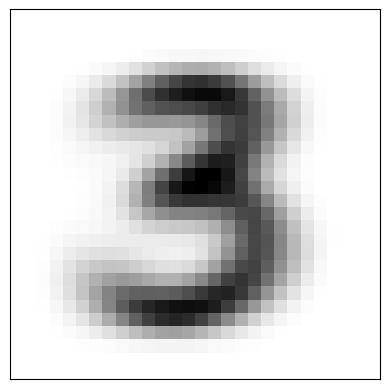

In [ ]:
mean = pca_threes.mean_

fig, ax = plt.subplots()  # add a subplot in a 1 x n_images_per_label grid
ax.imshow(mean.reshape((28, 28)), cmap='gray_r')  # reshape vector -> 28x28 and plot in grayscale
ax.set_xticks([]) # hide x-axis tick marks for cleaner image display
ax.set_yticks([]) 

### 🚩 Exercise 7 (CORE)

Plot the the first four basis vectors as images by accessing the `components_` attribute. What patterns do they seem to describe? 

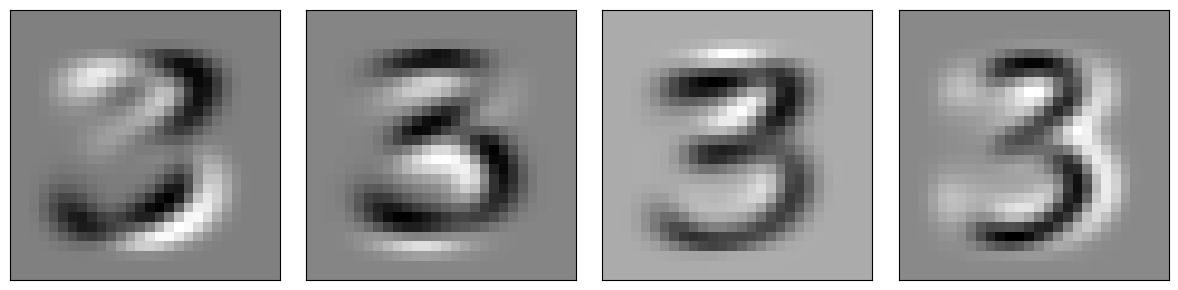

In [ ]:
comp = pca_threes.components_  # The components of the PCA

fig = plt.figure(figsize=(12, 3))  # Optional: set figure size

for j, img in enumerate(comp[:4]):  # Use enumerate to get index j
    ax = fig.add_subplot(1, 4, j + 1)  # top row: centred images
    ax.imshow(img.reshape((28, 28)), cmap='gray_r')  # reshape vector -> 28x28 and plot in grayscale
    ax.set_xticks([])  # hide x-axis tick marks for cleaner image display
    ax.set_yticks([]) 

fig.tight_layout()  # adjust subplot spacing
plt.show()  



The images seem to capture a significant portion of the variability explained by the principal components. In other words, the first few principal components will deviate the most from the mean 3.

### 🚩 Exercise 8 (CORE)

a) Use the `transform()` method to compute the PCA scores and save them in an object called `scores`. Then, plot the data points in the low-dimensional space spanned by the first two principal components. 

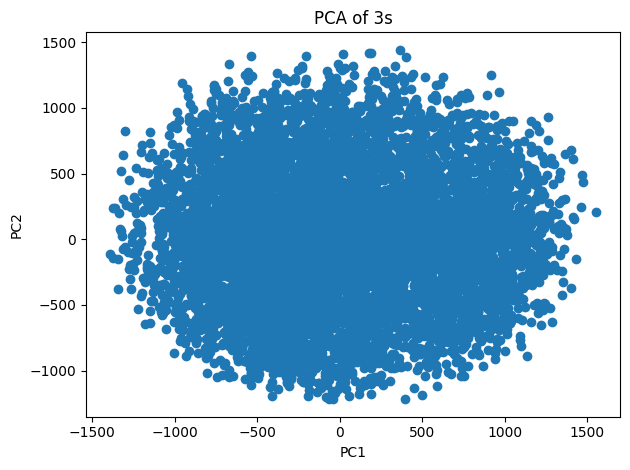

In [28]:
scores = pca_threes.transform(X_threes) # compute pca scores

fig, ax = plt.subplots() 

pc1 = scores[:,0]
pc2 = scores[:,1]

scatter = ax.scatter(pc1, pc2)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA of 3s')
plt.tight_layout()
plt.show()

To better interpret the latent dimensions, let's look at some projected points along each dimension and the corresponding images. Specifically, run the following code to:

- first compute the $5, 25, 50, 75, 95\%$ quantiles of the scores for the first two dimensions
- then find the data point whose projection is closest to each combination of quantiles.

In [29]:
s1q = np.quantile(scores[:, 0], [.05, .25, .5, .75, .95])  # compute 5/25/50/75/95% quantiles for PC1 scores
s2q = np.quantile(scores[:, 1], [.05, .25, .5, .75, .95])  # compute 5/25/50/75/95% quantiles for PC2 scores

idx = np.zeros([len(s1q), len(s2q)])  # allocate array to store indices of closest points to each (PC1, PC2) quantile pair

for i in range(len(s1q)):  # loop over PC1 quantiles
    for j in range(len(s2q)):  # loop over PC2 quantiles
        aux = ((scores[:, 0] - s1q[i]) ** 2 + (scores[:, 1] - s2q[j]) ** 2).reshape(N, 1)  # squared distance to target quantile pair
        idx[i, j] = np.where(aux == min(aux))[0][0]  # index of the point with minimum distance (closest projection)

idx = idx.astype(int)  # cast indices to integers for array indexing

b) Now, add these points in red to your plot above in.

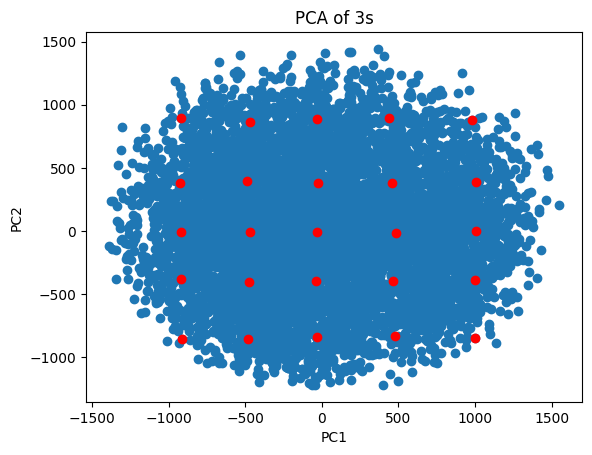

In [32]:
scores = pca_threes.transform(X_threes)

pc1 = scores[:,0]
pc2 = scores[:,1]

fig, ax = plt.subplots()

scatter = ax.scatter(scores[:,0], scores[:,1])
red = ax.scatter(pc1[idx.flatten()], pc2[idx.flatten()], color='red')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA of 3s')
plt.show()

c) Run the following code to plot the images corresponding to this grid of points. Describe the general pattern of the first (left to right) and second (down to up) principal component.

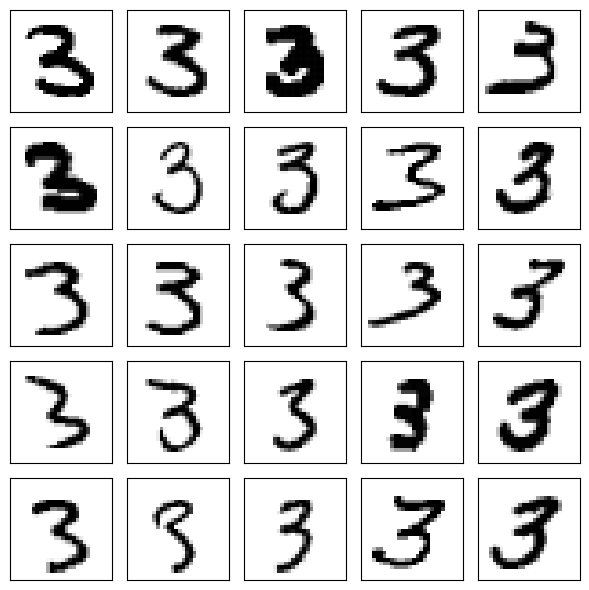

In [33]:
fig, ax = plt.subplots(len(s1q), len(s2q), figsize=(6, 6))  # create a grid of subplots (PC1 quantiles x PC2 quantiles)
for i in range(len(s1q)):  # iterate over PC1 quantile levels (columns)
    for j in range(len(s2q)):  # iterate over PC2 quantile levels (rows)
        ax[len(s2q) - 1 - j, i].imshow(X_threes[idx[i, j], :].reshape((28, 28)), cmap='gray_r')  # plot the closest image at that quantile pair
plt.setp(ax, xticks=[], yticks=[])  # remove axis ticks for all subplots
fig.tight_layout()  # reduce overlap and improve spacing

PC1(Left to Right): On the left the lines look thinner than the right side. Maybe the PC1 is capturing the instesity of the written number

PC2(Bottom to Top): On the bottom we can see more rounded lines, and in the top sharper strokes. PC2 looks like it is capturing the style of the 3. 

You can also try to create some artificial images, by fixing different values of the weights. This can also help to interpret the latent dimensions. 

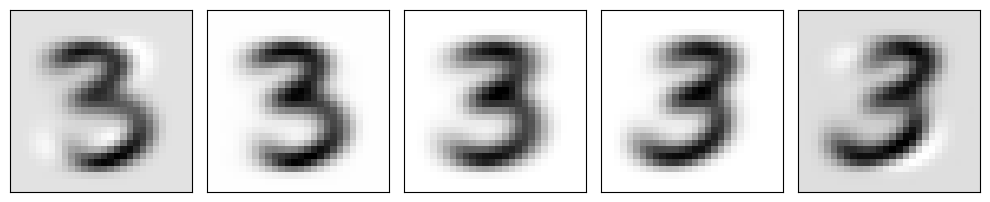

In [34]:
weight1 = np.quantile(scores[:, 0], [.05, .25, .5, .75, .95])  # choose representative PC1 score values via quantiles
weight2 = 0  # fix PC2 weight to 0 so we vary only along the first component

images_pc1 = np.zeros([len(weight1), D])  # allocate array for synthetic images (one per chosen PC1 weight)

count = 0  # counter to place each generated image into `images_pc1`
for w in weight1:  # iterate over selected PC1 weights
    images_pc1[count, :] = (pca_threes.mean_ + pca_threes.components_[0, :] * w + pca_threes.components_[1, :] * weight2)  # reconstruct from mean + weighted PCs
    count += 1  # move to next row in `images_pc1`
    

fig, ax = plt.subplots(1, len(weight1), figsize=(10, 6))  # create a row of subplots to display generated images
for i in range(len(weight1)):  # loop over the generated images
    ax[i].imshow(images_pc1[i, :].reshape((28, 28)), cmap='gray_r')  # reshape and show the i-th synthetic image
plt.setp(ax, xticks=[], yticks=[])  # remove ticks for cleaner presentation
fig.tight_layout()  # adjust layout to prevent overlap

### 🚩 Exercise 9 (CORE)

Repeat this to describe the third principal component. 

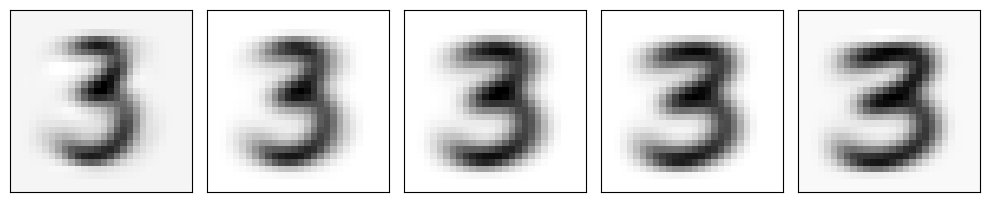

In [36]:
weight3 = np.quantile(scores[:, 2], [.05, .25, .5, .75, .95])  # choose representative PC3 score values via quantiles
weight2 = 0  # fix PC2 weight to 0 so we vary only along the third component
weight1 = 0  # fix PC1 weight to 0 so we vary only along the third component

images_pc3 = np.zeros([len(weight3), D])  # allocate array for synthetic images (one per chosen PC1 weight)

count = 0  # counter to place each generated image into `images_pc1`
for w in weight3:  # iterate over selected PC1 weights
    images_pc3[count, :] = (
        pca_threes.mean_
        + pca_threes.components_[0, :] * weight1
        + pca_threes.components_[1, :] * weight2
        + pca_threes.components_[2, :] * w)
    count += 1  # move to next row in `images_pc1`
    

fig, ax = plt.subplots(1, len(weight3), figsize=(10, 6))  # create a row of subplots to display generated images
for i in range(len(weight3)):  # loop over the generated images
    ax[i].imshow(images_pc3[i, :].reshape((28, 28)), cmap='gray_r')  # reshape and show the i-th synthetic image
plt.setp(ax, xticks=[], yticks=[])  # remove ticks for cleaner presentation
fig.tight_layout()  # adjust layout to prevent overlap

The PC3 is capturing how ... COMPLETE

### 🚩 Exercise 10 (EXTRA)

In lecture, we saw that we can also compute the basis vectors from an SVD decomposition of the data matrix. Use the `svd` function in `scipy.linalg` to compute the first three basis vectors and verify that they are the same (up to a change in sign -- note that the signs may be flipped because each principal component specifies a direction in the $D$-dimensional space and flipping the sign has no effect as the direction does not change). 

Does `PCA()` perform principal component analysis using an eigendecomposition of the empirical covariance matrix or using a SVD decomposition of the data matrix?

In [ ]:
# Code for your answer here!
from scipy.linalg import svd  # import singular value decomposition (SVD) for computing PCs via matrix factorisation


_Type your answer here!_

🏁 **Now, is a good point to switch driver and navigator**

## Selecting the Number of Components <a id='nocomponents'></a>

### 🚩 Exercise 11 (CORE)

Next, let's investigate how many components are needed by considering how much variance is explained by each component.

Note that the `pca_threes` object has an attribute `explained_variance_` (variance of each component) and `explained_variance_ratio_` (proportion of variance explained by each component). 

Plot both the proportion of variance explained and the cummulative proportion of variance explained. Provide a suggestion of how many components to use. How much variance is explained by the suggest number of components? Comment on why we may be able to use this number of components in relation to the total number of features.

<br>
<details><summary><b><u>Hint</b></u></summary>

You can use `cumsum()` to compute the cummulative sum of the elements in a vector.
</details>

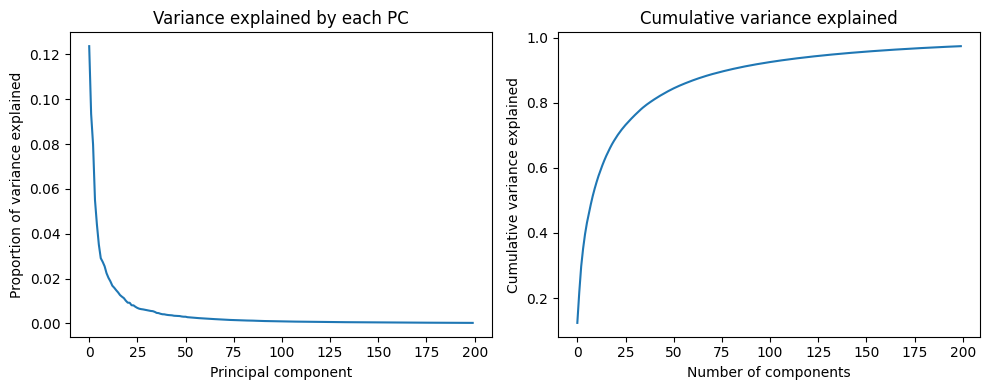

In [40]:
var = pca_threes.explained_variance_
var_r = pca_threes.explained_variance_ratio_

cum_var_r = np.cumsum(var_r)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Individual variance explained
ax[0].plot(var_r)
ax[0].set_xlabel('Principal component')
ax[0].set_ylabel('Proportion of variance explained')
ax[0].set_title('Variance explained by each PC')

# Cumulative variance explained
ax[1].plot(cum_var_r)
ax[1].set_xlabel('Number of components')
ax[1].set_ylabel('Cumulative variance explained')
ax[1].set_title('Cumulative variance explained')

plt.tight_layout()
plt.show()

_Type your answer here!_ 

### 🚩 Exercise 12 (CORE)

For your selected number of components, compute the reconstruted images. Plot the reconstruction for a few images and compare with the original images. Comment on the results.  

<br>
<details><summary><b><u>Hint</b></u></summary>

You can use `inverse_transform()` to decode the scores.
</details>

In [ ]:
# Code for your answer here!

_Type your answer here!_

🏁 **Now, is a good point to switch driver and navigator**

## Other Digits <a id='other'></a>

Now, let's consider another digit. 

### 🚩 Exercise 13 (CORE)

Perform PCA for another choice of digit. What do the first two components describe? Do some digits have better approximations than others? Comment on why this may be.

In [ ]:
# Cpde for your answer here!

_Type your answer here!_

### Exercise 14 (EXTRA)

Finally, consider now two digits of your choice (edit the code below if you wish to pick different digits).


In [ ]:
# Extract data  
X_twodigits = np.concatenate((digits_dict['3'], digits_dict['8']))  # stack all '3' and all '8' images into one dataset
N, D = X_twodigits.shape  # store dataset size: N images (rows), D pixels/features (columns)

Run the following code to compute and plot the mean and some of the principle components for this dataset. 

In [ ]:
# Fit PCA
pca_digits = PCA(n_components=50)  # create PCA transformer keeping the first 50 components
pca_digits.fit(X_twodigits)  # fit PCA on the two-digit dataset (learns mean and components)

In [ ]:
# Plot the mean image
fig = plt.figure(figsize=(5, 5))  # create a square figure for the mean digit image
ax = fig.add_subplot(111)  # add a single subplot occupying the whole figure
ax.imshow(pca_digits.mean_.reshape(28, 28), cmap='gray_r')  # reshape mean vector to 28x28 and display in grayscale
ax.set_xticks([])  # remove x-axis ticks
ax.set_yticks([])  # remove y-axis ticks
fig.tight_layout()  # tidy spacing

In [ ]:
# Plot basis vectors
n_plot = 5  # number of principal components to visualise
fig, ax = plt.subplots(1, 5, figsize=(10, 4))  # create a row of 5 subplots for the first 5 PCs
for n in range(n_plot):  # loop over the first `n_plot` principal components
  ax[n].imshow(pca_digits.components_[n, :].reshape((28, 28)), cmap='gray_r')  # reshape PC vector to 28x28 and display
plt.setp(ax, xticks=[], yticks=[])  # remove ticks on all subplots
fig.tight_layout()  # adjust spacing

Plot the projection of the data in the latent space and color the data by the labels. What do you observe?

In [ ]:
# Code for your answer here!

_Type your answer here!_

Try also to generate artificial images and decsribe how images change along the PCs. 

In [ ]:
# Code for your answer here!

_Type your answer here!_

# Kernel PCA <a id='kpca'></a>

Now, let's try using kernel PCA, which is available through sklearn's [`KernelPCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html) transformer. As usual we start by creating our object and specifying parameters (see documentation to learn more about the optional parameters). Then, we use the methods `.fit()` and `.transform()` to fit the object and obtain the lower-dimensional representation.

In the code below, we use the radial basis function kernel, with the inverse bandwith parameter `gamma` set to 0.05. Setting, the option `fit_inverse_transform=True` will allow us to reconstruct the images later (and `alpha` is regularization used when inversing the transforming).

_Note:_ we first subsampled the data, as kernel PCA can be slow on large datasets.  

In [ ]:
from sklearn.decomposition import KernelPCA  # kernel PCA transformer for nonlinear dimensionality reduction
from sklearn.model_selection import train_test_split  # utility to split arrays into train/test subsets
from sklearn.preprocessing import MinMaxScaler  # scaler to map features into a fixed range (default [0, 1])

# Prepare data
y_twodigits = y_twodigits.astype(int)  # ensure labels are integer-coded (useful for comparisons/plotting)
X_twodigits = MinMaxScaler().fit_transform(X_twodigits)  # scale pixel values to [0, 1] before applying kernels

# Subsample the images (for speed)
X_twodigits_subsampled, X_twodigits_test, y_twodigits_subsampled, y_twodigits_test = train_test_split(  # split into a smaller training subset and a held-out test set
    X_twodigits,  # full feature matrix for the two digits
    y_twodigits,  # corresponding digit labels
    stratify=y_twodigits,  # preserve class proportions in both splits
    random_state=0,  # seed for reproducibility
    train_size=500,  # number of samples to keep for fitting (subsample)
    test_size=100  # number of samples to reserve for evaluation/denoising
)  # end train/test split call

# Define our KPCA and PCA transformers
n_components = 10  # number of latent dimensions/components to keep
kpca = KernelPCA(  # construct the kernel PCA model
    n_components=n_components,  # dimensionality of the KPCA embedding
    kernel="rbf",  # radial basis function (Gaussian) kernel
    gamma=0.05,  # inverse bandwidth for the RBF kernel (controls nonlinearity)
    fit_inverse_transform=True,  # enable approximate inverse mapping for reconstructions
    random_state=0,  # seed (used in some solver paths)
    alpha=0.01  # regularisation for the inverse transform
)  # end KPCA model definition

pca = PCA(n_components=n_components)  # define standard (linear) PCA baseline with the same number of components

# Fit and transform the data
scores_kpca = kpca.fit_transform(X_twodigits_subsampled)  # fit KPCA on the subsample and return low-D scores
scores_pca = pca.fit_transform(X_twodigits_subsampled)  # fit PCA on the subsample and return low-D scores

Next, let's plot the images in the space of the first two components for both kernel PCA and standard PCA.

In [ ]:
# Plot the images in the space of the first two components, colored by digit
i, j = 0, 1  # component indices to plot (0-based: first vs second component)
yu = [3, 8]  # the digit classes to plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # create a 1x2 panel: KPCA scatter (left) vs PCA scatter (right)
for dig in yu:  # loop over the digit classes so each class gets its own colour/label
    ax[0].scatter(  # scatter plot for kernel PCA scores
        scores_kpca[y_twodigits_subsampled == dig, i],  # x-coordinates: component i scores for this digit
        scores_kpca[y_twodigits_subsampled == dig, j],  # y-coordinates: component j scores for this digit
        c=colors[dig],  # point colour for this digit class
        label=dig  # legend label for this digit class
    )  # end KPCA scatter
    ax[1].scatter(  # scatter plot for standard PCA scores
        scores_pca[y_twodigits_subsampled == dig, i],  # x-coordinates: component i scores for this digit
        scores_pca[y_twodigits_subsampled == dig, j],  # y-coordinates: component j scores for this digit
        c=colors[dig],  # point colour for this digit class
        label=dig  # legend label for this digit class
    )  # end PCA scatter
ax[0].legend()  # show legend for the kernel PCA panel
ax[0].set_xlabel('PCA%d' % (i + 1))  # label x-axis with component number (1-based for display)
ax[0].set_ylabel('PCA%d' % (j + 1))  # label y-axis with component number (1-based for display)
ax[0].set_title('Kernel PCA')  # title for the kernel PCA subplot
ax[1].legend()  # show legend for the standard PCA panel
ax[1].set_xlabel('PCA%d' % (i + 1))  # label x-axis for the PCA subplot
ax[1].set_ylabel('PCA%d' % (j + 1))  # label y-axis for the PCA subplot
ax[1].set_title('Standard PCA')  # title for the standard PCA subplot
plt.show()  # render the figure

### Image Denoising
Let's add some noise to our test images that weren't used in the fitting. We will then encode the noisy images into the latent space and then reconstruct our images, to see how well both methods are able to denoise the images.

In [ ]:
# Add noise to the test images
np.random.seed(0)  # set RNG seed so the added noise is reproducible
noise = np.random.normal(0, 0.1, X_twodigits_test.shape)  # sample Gaussian noise with mean 0 and std 0.1
X_twodigits_test_noisy = X_twodigits_test + noise  # create noisy test images by adding noise pixel-wise

# Plot some noisy test images
n_images = 5  # number of test images to visualise
fig, ax = plt.subplots(2, n_images, figsize=(2 * n_images, 4))  # create a 2-row grid: original (top) vs noisy (bottom)
for j in range(n_images):  # loop over a few example images
    ax[0, j].imshow(X_twodigits_test[j].reshape((28, 28)), cmap='gray_r')  # plot original image j
    ax[1, j].imshow(X_twodigits_test_noisy[j].reshape((28, 28)), cmap='gray_r')  # plot noisy version of image j
plt.setp(ax, xticks=[], yticks=[])  # remove ticks on all axes for cleaner display
# Add titles
ax[0, 2].set_title('Original Images')  # title for the original row (placed on the middle subplot)
ax[1, 2].set_title('Noisy Images')  # title for the noisy row (placed on the middle subplot)
fig.tight_layout()  # adjust spacing to avoid overlaps

In [ ]:
# Now transform the noisy test images using both PCA and KernelPCA
scores_kpca_test = kpca.transform(X_twodigits_test_noisy)  # encode noisy test images into KPCA latent space
scores_pca_test = pca.transform(X_twodigits_test_noisy)  # encode noisy test images into PCA latent space

# And reconstruct the noisy test images using both PCA and KernelPCA
X_reconstructed_kpca = kpca.inverse_transform(  # decode KPCA scores back to pixel space (approximate inverse)
    scores_kpca_test  # the KPCA scores for noisy test images
)  # end KPCA reconstruction
X_reconstructed_pca = pca.inverse_transform(  # decode PCA scores back to pixel space
    scores_pca_test  # the PCA scores for noisy test images
)  # end PCA reconstruction

# Plot some reconstructed images
n_images = 5  # number of images to show in each row
fig, ax = plt.subplots(4, n_images, figsize=(2 * n_images, 8))  # create a 4-row grid: original, noisy, KPCA recon, PCA recon
for j in range(n_images):  # loop over the selected test images
    ax[0, j].imshow(X_twodigits_test[j].reshape((28, 28)), cmap='gray_r')  # plot original image j
    ax[1, j].imshow(X_twodigits_test_noisy[j].reshape((28, 28)), cmap='gray_r')  # plot noisy image j
    ax[2, j].imshow(X_reconstructed_kpca[j].reshape((28, 28)), cmap='gray_r')  # plot KPCA reconstruction of image j
    ax[3, j].imshow(X_reconstructed_pca[j].reshape((28, 28)), cmap='gray_r')  # plot PCA reconstruction of image j
plt.setp(ax, xticks=[], yticks=[])  # remove ticks on all subplots
# Add titles
ax[0, 2].set_title('Original Images')  # title for the original row (placed in the middle column)
ax[1, 2].set_title('Noisy Images')  # title for the noisy row
ax[2, 2].set_title('Reconstructed Images (Kernel PCA)')  # title for the KPCA reconstruction row
ax[3, 2].set_title('Reconstructed Images (Standard PCA)')  # title for the PCA reconstruction row
fig.tight_layout()  # adjust subplot spacing

### Exercise 15 (EXTRA)

a) Try changing the `gamma`. What happens when you increase, e.g. `gamma=0.1`? Or decrease `gamma=0.01`? 

b) Try changing the number of components. How does this affect the reconstructed images for both PCA and kernel PCA?

c) Which method would you prefer for this dataset?


_Type your answer here!_

# Competing the Worksheet

At this point you have hopefully been able to complete all the CORE exercises and attempted the EXTRA ones. Now 
is a good time to check the reproducibility of this document by restarting the notebook's
kernel and rerunning all cells in order.

Before generating the PDF, please **change 'Student 1' and 'Student 2' at the top of the notebook to include your name(s)**. 

Once that is done and you are happy with everything, you can then run the following cell 
to generate your PDF.

In [ ]:
!jupyter nbconvert --to pdf mlp_week02_key.ipynb